# Setting Up the Problem

Conceivably, humanity will have the technology to create Pokéballs that safely unleash Pokémon at high velocity. As the proactive physicists we are, once The Pokémon Association takes this direction, we want to provide the elementary computations to making High Velocity Pokéball Services (HVPS) a reality.

### Specifications
Computational physics and research alike require baby steps. Approximating the delivery projectile to a sphere and assuming a smooth topology of the Earth simplifies computations immensely. The solution to this simplified problem gives the scientific community a direction.

Given these assumptions, this code calculates the trajectory of a 6kg Pokéball (4.8cm in diameter) traveling 10.79km.

Due to inside information, our trainer knows his first opponent will start with a water type, so obviously it would be best to start with an electric type. Fortunately, our trainer has a level 100 Pikachu (somehow it hasn't evolved yet...). Because conservation of mass dictates that the Pokémon in its Pokéball must weigh the same as a Pokémon outside of the Pokéball, and we assume Pikachu weighs more than the Pokéball, the Pokéball that our trainer must throw weighs about as much as a Pikachu. Our trainer's Pikachu weighs 6.0 kg and any Pokéball has a diameter of 4.8 cm. 

A certain Pokémon trainer has an in-person lab at Rockefeller until 5 o'clock pm on Tuesday. Unfortunately for this trainer, there is a Pokémon tournament at Edgewater Park at 5:05 pm. One might think it is impossible for this trainer to participate in the tournament, but fear not! In the age of Zoom, the trainer can throw, using his pocket railgun, his Pokéball towards the park and zoom into the tournament to give moves to his Pokémon as he frantically sprints through the streets of Cleveland towards Edgewater Park. This way, the Pokémon trainer can participate in the tournament, but not leave his lab partner alone in a cold, dark, cement room. 



### Initalizing

In [27]:
import numpy as np
import scipy.optimize as opt
import scipy.interpolate as interp
import mpl_toolkits.mplot3d.axes3d as axes3d

import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)

import math
import matplotlib.pyplot as plt
%matplotlib inline
import time
import scipy.integrate as integ
import scipy.special as sp
import scipy.linalg as la
import numpy.random as random
from matplotlib import animation, rc
from IPython.display import display, clear_output, HTML, Image

def s2cart1 (r, t, p) :
    '''
    This calculates cartesian coordinates from spherical coordinates
    This requires inputs of:
    r which is the radius
    t which is the theta angle
    p which is the phi angle
    This returns the cartesian coordinates of the vector
    x which is the x component
    y which is the y component
    z which is the z component
    '''
    x = r * np.cos(p) * np.sin(t)
    y = r * np.sin(t) * np.sin(p)
    z = r * np.cos(t)
    return np.array([x, y, z])
s2cart = np.vectorize(s2cart1) # Allows s2cart1 to act on an entire array of values

def cart2s1 (x, y, z) :
    '''
    This calculates spherical coordinates from cartesian coordinates
    This requires inputs of:
    x which is the x component
    y which is the y component
    z which is the z component
    This returns the cartesian coordinates of the vector
    r which is the radius
    t which is the theta angle
    p which is the phi angle
    '''
    r = np.sqrt(x**2 + y**2 + z**2)
    p = np.arctan2(y, x)
    t = np.arccos(z/r)
    return np.array([r, t, p]) 

def plot_bvp_obj(ans, ibc, fbc) :
    '''
    Final plotting format for our True solution
    It plots the spherical components of our position with respect to time and the magnitude of the velocity of the projectile
    This requires inputs of:
    ans which is the output of a solve_bvp function evaluation
    ibc which are the initial boundary conditions 
        ibc[0]=initial condition in x direction
        ibc[1]=initial condition in y direction
        ibc[2]=initial condition in z direction
    ifbc which are the final boundary conditions 
        fbc[0]=final condition in x direction
        fbc[1]=final condition in y direction
        fbc[2]=final condition in z direction
    '''
    plt.figure(figsize = (15, 10))
    plt.plot(ans.x, cart2s1(ans.y[0], ans.y[1], ans.y[2])[0], label = 'r', c = 'r')
    plt.scatter(np.array([ans.x[0], ans.x[-1]]), np.array([cart2s1(*ibc)[0], cart2s1(*fbc)[0]]), c = 'black', label = 'Boundary Conditions')
    plt.grid()
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('r')
    plt.title('Numeric Radius vs. Time')
    plt.show()

    plt.figure(figsize = (15, 10))
    plt.plot(ans.x, cart2s1(ans.y[0], ans.y[1], ans.y[2])[2], label = r'$\phi$', c = 'r')
    plt.scatter(np.array([ans.x[0], ans.x[-1]]), np.array([cart2s1(*ibc)[2], cart2s1(*fbc)[2]]), c = 'black', label = 'Boundary Conditions')
    plt.grid()
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel(r'$\phi$')
    plt.title(r'Numeric $\phi$ vs. Time')
    plt.show()
    
    plt.figure(figsize = (15, 10))
    plt.plot(ans.x, cart2s1(ans.y[0], ans.y[1], ans.y[2])[1], label = r'$\theta$', c = 'r')
    plt.scatter(np.array([ans.x[0], ans.x[-1]]), np.array([cart2s1(*ibc)[1], cart2s1(*fbc)[1]]), c = 'black', label = 'Boundary Conditions')
    plt.grid()
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel(r'$\theta$')
    plt.title(r'Numeric $\theta$ vs. Time')
    plt.show()

    plt.figure(figsize = (15, 10))
    plt.plot(ans.x, np.sqrt(ans.y[3]**2 + ans.y[4]**2 + ans.y[5]**2), label = 'Numeric velocity', c = 'r')
    plt.grid()
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('v')
    plt.title('Numeric Linear Velocity vs. Time')
    plt.show()
    
    return

# Physics
### Assumptions

We will assume STP at sea level and that pressure varries with altitude. We have some fittings from Nasa. Their models depend on the layer of the atmosphere we are in which makes them easier to implement than the discrete model from the AVS.  However, we need to learn how to implement piecewise function or something similiar to pass in this behavior into the function. https://www.grc.nasa.gov/WWW/K-12/airplane/atmosmet.html

Inside the troposphere, $h<11000m$ the temperature is given by the equation $T=15.04 - 0.00649h$ where T is expressed in units of Celsius.  The pressure in this height range is given by $p=101.29(\frac{T+273.1}{288.08})^{5.256}$ where the pressure is measured in KPa.

Inside the lower Stratosphere, $11000m<h<25000m$ the temperature is nearly constant at -56.46C.  The pressure is described by the equation $22.65*e^{1.73-0.000157h}$ where is is again expressed in KPa.

Finally inside the upper Stratosphere for $h>25000m$ the temperature is no linger constant at $T=-131.21+0.00299h$ where it is expressed in Celsius.  The pressure at this height is described by the equation $p=2.488*(\frac{T+273.1}{216.6})^{-11.388}$ where is has units of KPa.

Finally, in all of these heights the density of air follows a single equation.  It is $\rho=\frac{p}{0.2689*(T+273.1)}$ in units of $kg/m^3$.

To sum up all of the previous equations into one piece wise expression:
$$
  \rho(T,h) = \frac{1}{0.2698(T+273.1)} 
  \begin{cases}
                                   101.29(\frac{T+273.1}{288.08})^{5.256} & \text{if $h<11000m$} \\
                                   22.65 e^{1.73-0.000157h} & \text{if $11000m<h<25000m$} \\
                                   2.488(\frac{T+273.1}{216.6})^{-11.388} & \text{if $h>25000m$}.
  \end{cases}
$$


Then if the temperatures are plugged in:         

$$
  \rho(h) = 
  \begin{cases}
                                   \frac{101.29}{77.740172-0.001751h}(\frac{288.4-0.00649h}{288.08})^{5.256} & \text{if $h<11000m$} \\
                                   0.38751419e^{1.73-0.000157h} & \text{if $11000m<h<25000m$} \\
                                   \frac{2.488}{38.281922+0.000806702h}(\frac{141.89+0.00299h}{216.6})^{-11.388} & \text{if $h>25000m$}
  \end{cases}
$$
where h is the altitude.  This means this is the height above sealevel.  However, our coordinate system models via the radius from the center of the earth, meaning $h=r-r_{Earth}$.  The radius of the Earth is approximately 6371km from https://nssdc.gsfc.nasa.gov/planetary/factsheet/earthfact.html.

This approximation means we can further substitute into $\rho$ to find the density at a certain radius from the center of the Earth.
$$
\rho(x,y,z) = 
  \begin{cases}
                                   \frac{101.29}{77.740172-0.001751(\sqrt{x^2+y^2+z^2}-6371000)}(\frac{288.4-0.00649(\sqrt{x^2+y^2+z^2}-6371000)}{288.08})^{5.256} & \text{if $\sqrt{x^2+y^2+z^2}<6382000m$} \\
                                   0.38751419e^{1.73-0.000157(\sqrt{x^2+y^2+z^2}-6371000)} & \text{if $6382000m<\sqrt{x^2+y^2+z^2}<6396000m$} \\
                                   \frac{2.488}{38.281922+0.000806702(\sqrt{x^2+y^2+z^2}-6371000)}(\frac{141.89+0.00299(\sqrt{x^2+y^2+z^2}-6371000)}{216.6})^{-11.388} & \text{if $\sqrt{x^2+y^2+z^2}>6396000m$}
  \end{cases}
$$

In [2]:
# Constants that we'll use later:
r_earth = 6.371E6 # m
g = 9.807 # m/s^2
omega_earth = s2cart1(2*np.pi/(3600*24), 72.68, 80.65)

def density (r) :
    '''
    Returns air density as a function of radius (r)
    r is calculated before plugged into this.  It is the norm of the vector components of the position
    With a radius less than the Earth, gamma is an extremely large number to force the ball to want to travel outside of the Earth's surface
    '''
    if r < r_earth-1 :
        return 100000 # This is a test to force the projectile to dislike going through the cetner of the Earth
    
    if r < 6382000 :
        return 101.29 / (77.740172 - 0.001751 * (r - r_earth)) * ((288.4 - 0.00649 * (r - r_earth))/288.08) ** 5.256
    
    
    if (6382000 < r) & (r < 6396000) :
        return 0.38751419 * np.exp(1.73 - 0.000157 * (r - r_earth))
    
    if r > 6396000 :
        return (0.2 * np.pi) * 2.488 / (38.281922 + 0.000806702 * (r - r_earth)) * ((141.89 + 0.00299 * (r - r_earth)) / 216.6) ** (-11.388)

### The Centrifugal Force and Coriolis Force

These are two fictious forces that occur to act on the moving projectile due to the Earth spinning below the particle as it travels its path.  After leaving the surface of the Earth, the particle continues on its predetermined trajectory regardless of the Earth's spinning.  The equation for acceleration take the form of (Unfortunately there are no bold $\Omega$ inside the markdown) 
$$m\ddot{\textbf{R}}=\textbf{F}_g+2m\dot{\textbf{R}}\times\vec{\Omega} +m(\vec{\Omega} \times \textbf{R}) \times \vec{\Omega}$$ 
where $\textbf{F}_g$ is the force the particle feels in spherical coordinates, and $\Omega$ is the angular velocity of the Earth [Taylor]. From NOAA, we know the lattitude and longitude of the geomagnetic poles, which we can convert to cartesian. We end up with $\vec{\Omega} = \{ \frac{2 \pi}{3600 \times 24}, 72.68, 80.65 \}$

### Air Resistance

Air resistance occurs linearly due to the vicious drag through the air medium.  It occurs quadratically due to the density of the medium and cross sectional area of the particle $$m\ddot{\textbf{R}}=\textbf{F}_g-\beta D\dot{\textbf{R}}-\gamma D^2 \dot{\textbf{R}}^2\frac{\dot{\textbf{R}}}{|\dot{\textbf{R}}|}$$ where $D$ is the diameter of our spherical ball, and $\beta$ and $\gamma$ are constants of the medium.  These however may change as pressure and temperature change as the ball rises upwards in the atmosphere.  It is up to us whether or not we want to consider quadratic air resistance. At STP $\beta$ is $1.6*10^{-4}$ $Ns/m^2$ and $\gamma$ is $0.25$ $Ns^2/m^4$.

As it turns out, at high velocities the linear drag becomes negligible in comparison to the quadratic drag.  The quadratic drag is further described by the equation
$$F_D=\frac{C_D A \rho v^2}{2}$$ where $C_D$ is the coefficient of drag, A is the front area, $\rho$ is the density of the air, and v is the velocity of the ball.  This is only true for large Reynolds numbers which are described by $Re=\frac{vD}{\nu}$ where D is the diameter of the sphere, and $\nu$ is the kinematic viscosity of the fluid.  For air, $\nu$ is about $1.516*10^{-5}$ $m^2/s$ at STP.  This stays in the same magnitude as the temperature drops, so for an approximation $Re$ should be large enough for the approximation.  Assuming the ball will be traveling quite fast its entire journey, its $C_D\approx 0.2$.

This means $$\gamma=\frac{0.2\pi \rho}{8}$$ where the density of air depends on the height off of the ground and the temperature and pressure of the atmosphere.  As we will find later, density is a function of the temperature and height, and as such is compeltely determined by NASA's piecewise functions of the atmosphere.[Fundamentals of Thermal-fluid Sciences textbook]

In [3]:
def gamma1(x, y, z):
    '''
    Finds gamma, which is the
    air density multiplied by 0.2pi and divided by 8
    Inputs are x,y,z corresponding to the vector positions of the projectile in the solutions
    This outputs the value of gamma
    '''
    r = la.norm(np.array([x,y,z]),axis=0)
    gamma = 0.2*np.pi*density(r)/8
    return gamma

gamma_real = np.vectorize(gamma1)

### Dividing into 6 Differential Equations

The first trivial 3 of 6 total differential equations: 
$$\boxed{\dot{x}=\frac{dx}{dt}}$$
$$\boxed{\dot{y}=\frac{dy}{dt}}$$
$$\boxed{\dot{z}=\frac{dz}{dt}}$$

This is the equation we are starting with: $$m\ddot{\textbf{R}}=\textbf{F}+2m\dot{\textbf{R}}\times\vec{\Omega} +m(\vec{\Omega} \times \textbf{R}) \times \vec{\Omega} -\gamma D^2 \dot{R}^2 \frac{\dot{\textbf{R}}}{|\dot{\textbf{R}}|}$$ 

$$ m (\ddot{x}\hat{x} + \ddot{y}\hat{y} + \ddot{z}\hat{z}) = -\frac{m g(x\hat{x}+y\hat{y}+z\hat{z})}{(x^2 + y^2 + z^2)^{1/2}} + 2 m [(\dot{x}\hat{x} + \dot{y}\hat{y} + \dot{z}\hat{z}) \times \vec{\Omega}] + m [[\vec{\Omega} \times (x \hat{x} + y \hat{y} + z \hat{z})] \times \vec{\Omega}] - \gamma (x,y,z) D^2 \sqrt{\dot{x}^2 + \dot{y}^2 + \dot{z}^2} (\dot{x}\hat{x} + \dot{y}\hat{y} + \dot{z}\hat{z}) $$

$$ (\dot{x}\hat{x} + \dot{y}\hat{y} + \dot{z}\hat{z}) \times \vec{\Omega} = (\dot{y} \Omega_z - \dot{z} \Omega_y) \hat{x} + (\dot{z} \Omega_x - \dot{x} \Omega_z) \hat{y} + (\dot{x} \Omega_y - \dot{y} \Omega_x) \hat{z} $$
$$ \vec{\Omega} \times (x \hat{x} + y \hat{y} + z \hat{z}) = (\Omega_y z - \Omega_z y)\hat{x} + (\Omega_z x - \Omega_x z)\hat{y} + (\Omega_x y - \Omega_y x)\hat{z} $$
$$ [\vec{\Omega} \times (x \hat{x} + y \hat{y} + z \hat{z})] \times \vec{\Omega} = ((\Omega_z x - \Omega_x z) \Omega_z - (\Omega_x y - \Omega_y x) \Omega_y)\hat{x} + ((\Omega_x y - \Omega_y x) \Omega_x - (\Omega_y z - \Omega_z y) \Omega_z)\hat{y} + ((\Omega_y z - \Omega_z y) \Omega_y - (\Omega_z x - \Omega_x z) \Omega_x)\hat{z} $$

But because each unit vector is orthogonal, we can spearate these into components:
$$ \ddot{x} = -\frac{g x}{(x^2 + y^2 + z^2)^{1/2}} + 2(\dot{y} \Omega_z - \dot{z} \Omega_y) + ((\Omega_z x - \Omega_x z) \Omega_z - (\Omega_x y - \Omega_y x) \Omega_y) - \gamma (x,y,z) \frac{D^2}{m} \sqrt{\dot{x}^2 + \dot{y}^2 + \dot{z}^2} \dot{x} $$

$$ \ddot{y} = -\frac{g y}{(x^2 + y^2 + z^2)^{1/2}} + 2 (\dot{z} \Omega_x - \dot{x} \Omega_z) + ((\Omega_x y - \Omega_y x) \Omega_x - (\Omega_y z - \Omega_z y) \Omega_z) - \gamma (x, y, z) \frac{D^2}{m} \sqrt{\dot{x}^2 + \dot{y}^2 + \dot{z}^2} \dot{y} $$

$$ \ddot{z} = -\frac{g z}{(x^2 + y^2 + z^2)^{1/2}} + 2 (\dot{x} \Omega_y - \dot{y} \Omega_x) + ((\Omega_y z - \Omega_z y) \Omega_y - (\Omega_z x - \Omega_x z) \Omega_x) - \gamma (x, y, z) \frac{D^2}{m} \sqrt{\dot{x}^2 + \dot{y}^2 + \dot{z}^2} \dot{z} $$

Where subscripts denote a cross product and $\gamma(x,y,z) = \frac{0.2\pi\rho(x,y,z)}{8}$ as defined above.

### Using solve_bvp

Since we were able to decompose the entire system into 6 differential equations, we plan to implement all three in a function and input it into solve_bvp.  solve_bvp requires us to input a function full of boundary conditions, as well as an initial guess for the parameters.  An optional input, which we will include is the Jacobian of the function inputted into solve_bvp.  The order of the functions as we documented earlier in the code is:
$$
    y_0 = x\\
    y_1 = y\\
    y_2 = z\\
    y_3 = \frac{dx}{dt}\\
    y_4 = \frac{dy}{dt}\\
    y_5 = \frac{dz}{dt}\\
$$
where y is the function full of the solutions we should get out of solve_bvp. 

Our 6 EOM then become:
$$  f_{0} =y_3 \\
    f_{1} =y_4 \\
    f_{2} =y_5 \\
    f_{3}  = \left(-\frac{g y_0}{\sqrt{y_0^2+y_1^2+y_2^2}} + 2y_4 \Omega_z - 2y_5 \Omega_y + \Omega_z^2 y_0 - \Omega_x \Omega_z y_2 - \Omega_x \Omega_y y_1 + \Omega_y^2 y_0 - \gamma (y_0,y_1,y_2) \frac{D^2}{m} \sqrt{y_3^2 + y_4^2 + y_5^2} y_3\right) \\
    f_{4} =\left(-\frac{g y_1}{\sqrt{y_0^2+y_1^2+y_2^2}} + 2y_5 \Omega_x - 2y_3 \Omega_z + \Omega_x^2 y_1 - \Omega_y \Omega_x y_0 - \Omega_y \Omega_z y_2 + \Omega_z^2 y_1 - \gamma (y_0, y_1, y_2) \frac{D^2}{m} \sqrt{y_3^2 + y_4^2 + y_5^2} y_4\right) \\
    f_{5} =\left(-\frac{g y_2}{\sqrt{y_0^2+y_1^2+y_2^2}} + 2y_3 \Omega_y - 2y_4 \Omega_x + \Omega_y^2 y_2 - \Omega_y \Omega_z y_1 - \Omega_x \Omega_z y_0 + \Omega_x^2 y_2 - \gamma (y_0, y_1, y_2) \frac{D^2}{m} \sqrt{y_3^2 + y_4^2 + y_5^2} y_5\right) \\
    $$



In [4]:
def ddt_fun (t, pos, Omega, gamma_real, m, D) :
    """
    Returns dpdt, the derivatives of the position usable by solve_bvp.
    Calculates the derivatives of pos where
    
    pos[0] = x
    pos[1] = y
    pos[2] = x
    pos[3] = dx/dt
    pos[4] = dy/dt
    pos[5] = dz/dt
    
    Omega[0] = x value of the spin of the Earth
    Omega[1] = y value of the spin of the Earth
    Omega[2] = z value of the spin of the Earth
    
    gamma = term used to describe air resistance's effects against motion
    D = diameter of spherical ball
    m = mass of object
    ===============
    dpdt, a matrix the same size as pos, containing the first and
    second derivatives of pos
    dpdt[0] = dx/dTau
    dpdt[1] = dy/dTau
    dpdt[2] = dz/dTau
    dpdt[3] = dx^2/d^2Tau
    dpdt[4] = dy^2/d^2Tau
    dpdt[5] = dz^2/d^2Tau
    """
    dpdt = np.zeros_like(pos)
    
    # define some useful values
    frac = - g / la.norm(np.array([pos[0],pos[1],pos[2]]),axis=0)
    last_term = gamma_real(pos[0], pos[1], pos[2]) * D**2 / m * la.norm(np.array([pos[3],pos[4],pos[5]]),axis=0)
    
    dpdt[:3] = pos[3:]
    dpdt[3] = ( frac*pos[0]  + 2*( pos[4]*Omega[2] - pos[5]*Omega[1] )  + Omega[2]*( Omega[2]*pos[0] - Omega[0]*pos[2] )  - Omega[1]*( Omega[0]*pos[1] - Omega[1]*pos[0] )  - pos[3]*last_term )
    dpdt[4] = ( frac*pos[1]  + 2*( pos[5]*Omega[0] - pos[3]*Omega[2] )  + Omega[0]*( Omega[0]*pos[1] - Omega[1]*pos[0] )  - Omega[2]*( Omega[1]*pos[2] - Omega[2]*pos[1] )  - pos[4]*last_term )
    dpdt[5] = ( frac*pos[2]  + 2*( pos[3]*Omega[1] - pos[4]*Omega[0] )  + Omega[1]*( Omega[1]*pos[2] - Omega[2]*pos[1] )  - Omega[0]*( Omega[2]*pos[0] - Omega[0]*pos[2] )  - pos[5]*last_term )
    
    return dpdt

In [5]:
def bc(ya, yb, y_bc1, y_bc2 ) :
    '''
    This function takes in the boundary conditions needed to solve the problem.
    This needs to be called using a lambda function inside of solve_bvp since we are passing in the boundary conditions as vaguely as possible
    It takes in residuals for each of the boundary conditions.
    y_bc1 and y_bc2 are vectors filled with our boundary conditions.  These are only specified for the initial and final positions of the ball
    '''

    return np.array([ya[0] - y_bc1[0], ya[1] - y_bc1[1], ya[2] - y_bc1[2], yb[0] - 
                     y_bc2[0], yb[1] - y_bc2[1], yb[2] - y_bc2[2]])

Following this we can calculate the Jacobian of our function, which is nxn by hand in the form of:
$$J=\begin{bmatrix}
    \frac{\partial f_0}{\partial y_0} & \frac{\partial f_0}{\partial y_1} & \frac{\partial f_0}{\partial y_2} & \frac{\partial f_0}{\partial y_3} & \frac{\partial f_0}{\partial y_4} & \frac{\partial f_0}{\partial y_5} \\
    \frac{\partial f_1}{\partial y_0} &\frac{\partial f_1}{\partial y_1} & \frac{\partial f_1}{\partial y_2} & \frac{\partial f_1}{\partial y_3} & \frac{\partial f_1}{\partial y_4} & \frac{\partial f_1}{\partial y_5} \\
    \frac{\partial f_2}{\partial y_0} &\frac{\partial f_2}{\partial y_1} & \frac{\partial f_2}{\partial y_2} & \frac{\partial f_2}{\partial y_3} & \frac{\partial f_2}{\partial y_4} & \frac{\partial f_2}{\partial y_5} \\
    \frac{\partial f_3}{\partial y_0} &\frac{\partial f_3}{\partial y_1} & \frac{\partial f_3}{\partial y_2} & \frac{\partial f_3}{\partial y_3} & \frac{\partial f_3}{\partial y_4} & \frac{\partial f_3}{\partial y_5} \\
    \frac{\partial f_4}{\partial y_0} &\frac{\partial f_4}{\partial y_1} & \frac{\partial f_4}{\partial y_2} & \frac{\partial f_4}{\partial y_3} & \frac{\partial f_4}{\partial y_4} & \frac{\partial f_4}{\partial y_5} \\
    \frac{\partial f_5}{\partial y_0} &\frac{\partial f_5}{\partial y_1} & \frac{\partial f_5}{\partial y_2} & \frac{\partial f_5}{\partial y_3} & \frac{\partial f_5}{\partial y_4} & \frac{\partial f_5}{\partial y_5} \\
\end{bmatrix}$$
By stacking m of these arrays on top of each other, we calculate Jacobian needed df_dy for solve_bvp.

In this case we will approximate the partial derivatives of $\gamma$ with center differencing.  This will intorduce an error of order $x^2$, but we are evaluating it with a stepsize of 1.  Our function is likely never going to be evaluated at such small distances, so it is likely this won't impact the solution much:
$$J= \begin{bmatrix}
    0 & 0 & 0 & 1 & 0 & 0 \\
    0 & 0 & 0 & 0 & 1 & 0 \\
    0 & 0 & 0 & 0 & 0 & 1 \\
    -\frac{g}{\sqrt{y_0^2+y_1^2+y_2^2}}+\frac{g y_0^2}{(y_0^2+y_1^2+y_2^2)^{3/2}}+\Omega_z^2+\Omega_y^2-\frac{\gamma(y_0+1,y_1,y_2)-\gamma(y_0-1,y_1,y_2)}{4}\frac{D^2}{m} \sqrt{y_3^2 + y_4^2 + y_5^2} y_3 & 
    \frac{g y_0 y_1}{(y_0^2+y_1^2+y_2^2)^{3/2}}-\Omega_x \Omega_y- \frac{\gamma(y_0,y_1+1,y_2)-\gamma(y_0,y_1-1,y_2)}{4}\frac{D^2}{m}\sqrt{y_3^2 + y_4^2 + y_5^2} y_3 & 
    \frac{g y_0 y_2}{(y_0^2+y_1^2+y_2^2)^{3/2}}-\Omega_x \Omega_z- \frac{\gamma(y_0,y_1,y_2+1)-\gamma(y_0,y_1,y_2-1)}{4}\frac{D^2}{m}\sqrt{y_3^2 + y_4^2 + y_5^2} y_3 & 
    -\gamma \frac{D^2}{m}\sqrt{y_3^2 + y_4^2 + y_5^2} - \gamma \frac{D^2}{m}\frac{y_3^2}{\sqrt{y_3^2 + y_4^2 + y_5^2}} & 
    2\Omega_z - \gamma \frac{D^2}{m}\frac{y_3 y_4}{\sqrt{y_3^2 + y_4^2 + y_5^2}}& 
    -2\Omega_y - \gamma \frac{D^2}{m}\frac{y_3 y_5}{\sqrt{y_3^2 + y_4^2 + y_5^2}} \\
    \frac{g y_0 y_1}{(y_0^2+y_1^2+y_2^2)^{3/2}}-\Omega_y \Omega_x- \frac{\gamma(y_0+1,y_1,y_2)-\gamma(y_0-1,y_1,y_2)}{4}\frac{D^2}{m}\sqrt{y_3^2 + y_4^2 + y_5^2} y_4 &
    -\frac{g}{\sqrt{y_0^2+y_1^2+y_2^2}}+\frac{g y_1^2}{(y_0^2+y_1^2+y_2^2)^{3/2}}+\Omega_x^2+\Omega_z^2-\frac{\gamma(y_0,y_1+1,y_2)-\gamma(y_0,y_1-1,y_2)}{4}\frac{D^2}{m} \sqrt{y_3^2 + y_4^2 + y_5^2} y_4 & 
    \frac{g y_1 y_2}{(y_0^2+y_1^2+y_2^2)^{3/2}}-\Omega_y \Omega_z- \frac{\gamma(y_0,y_1,y_2+1)-\gamma(y_0,y_1,y_2-1)}{4}\frac{D^2}{m}\sqrt{y_3^2 + y_4^2 + y_5^2} y_4 & 
    -2\Omega_z- \gamma \frac{D^2}{m}\frac{y_3 y_4}{\sqrt{y_3^2 + y_4^2 + y_5^2}} & 
    -\gamma \frac{D^2}{m}\sqrt{y_3^2 + y_4^2 + y_5^2} - \gamma \frac{D^2}{m}\frac{y_4^2}{\sqrt{y_3^2 + y_4^2 + y_5^2}} & 
    2\Omega_x - \gamma \frac{D^2}{m}\frac{y_4 y_5}{\sqrt{y_3^2 + y_4^2 + y_5^2}} \\
    \frac{g y_0 y_2}{(y_0^2+y_1^2+y_2^2)^{3/2}}-\Omega_x \Omega_z- \frac{\gamma(y_0+1,y_1,y_2)-\gamma(y_0-1,y_1,y_2)}{4}\frac{D^2}{m}\sqrt{y_3^2 + y_4^2 + y_5^2} y_5 &
    \frac{g y_1 y_2}{(y_0^2+y_1^2+y_2^2)^{3/2}}-\Omega_y \Omega_z- \frac{\gamma(y_0,y_1+1,y_2)-\gamma(y_0,y_1-1,y_2)}{4}\frac{D^2}{m}\sqrt{y_3^2 + y_4^2 + y_5^2} y_5 & 
    -\frac{g}{\sqrt{y_0^2+y_1^2+y_2^2}}+\frac{g y_2^2}{(y_0^2+y_1^2+y_2^2)^{3/2}}+\Omega_x^2+\Omega_y^2-\frac{\gamma(y_0,y_1,y_2+1)-\gamma(y_0,y_1,y_2-1)}{4}\frac{D^2}{m} \sqrt{y_3^2 + y_4^2 + y_5^2} y_5 & 
    2\Omega_y - \gamma \frac{D^2}{m}\frac{y_3 y_5}{\sqrt{y_3^2 + y_4^2 + y_5^2}} & 
    -2\Omega_x - \gamma \frac{D^2}{m}\frac{y_4 y_5}{\sqrt{y_3^2 + y_4^2 + y_5^2}} & 
    -\gamma \frac{D^2}{m}\sqrt{y_3^2 + y_4^2 + y_5^2} - \gamma \frac{D^2}{m}\frac{y_5^2}{\sqrt{y_3^2 + y_4^2 + y_5^2}} \\
\end{bmatrix}$$

solve_bvp requires us to stack m of these Jacobians into the third array dimension.  This m is essentailly the stepsize (a.k.a the number of divisions in x and y) where the function must be evaluated.

In [6]:
def Jacobian(x,y,Omega,gamma_real,d,m,g):
    '''
    x is the array from 0 to 1 spanning our solution
    y contains the list of our function evaluated from ddt_fun.  
    gamma_real = term used to describe air resistance's effects against motion and is calling our function
    d = diameter of spherical ball
    m = mass of object
    Omega is a 3 part array:
        Omega[0]=Omega_x
        Omega[1]=Omega_y
        Omega[2]=Omega_z
    g is gravity which is a defined constant
    '''
    g0=(gamma_real(y[0]+1,y[1],y[2])-gamma_real(y[0]-1,y[1],y[2]))/4 #These g# calculate center diff approximation to gamma
    g1=(gamma_real(y[0],y[1]+1,y[2])-gamma_real(y[0],y[1]-1,y[2]))/4
    g2=(gamma_real(y[0],y[1],y[2]+1)-gamma_real(y[0],y[1],y[2]-1))/4
    gam=gamma_real(y[0],y[1],y[2]) # gamma evaluated at the point
    
    termz=np.zeros([ len(x)])
    termp=np.ones([len(x)])
    
    df_dy = np.empty((6, 6, x.shape[0]))
    
    normp = la.norm(np.array([y[0],y[1],y[2]]),axis=0)#position norm
    normp3 = normp**(-3) # position norm cubed
    normv = la.norm(np.array([y[3],y[4],y[5]]),axis=0) #velocity norm
    
    df_dy[0, 0] = termz
    df_dy[0, 1] = termz
    df_dy[0, 2] = termz
    df_dy[0, 3] = termp
    df_dy[0, 4] = termz
    df_dy[0, 5] = termz
    
    df_dy[1, 0] = termz
    df_dy[1, 1] = termz
    df_dy[1, 2] = termz
    df_dy[1, 3] = termz
    df_dy[1, 4] = termp
    df_dy[1, 5] = termz
    
    df_dy[2, 0] = termz
    df_dy[2, 1] = termz
    df_dy[2, 2] = termz
    df_dy[2, 3] = termz
    df_dy[2, 4] = termz
    df_dy[2, 5] = termp
    
    df_dy[3, 0] = - g / normp + g * y[0]**2 * normp3 + Omega[2]**2 + Omega[1]**2 - g0 * d**2 * normv * y[3] / m
    df_dy[3, 1] = g * y[0] * y[1] * normp3 - Omega[0] * Omega[1] - g1 * d**2 * normv * y[3] / m
    df_dy[3, 2] = g * y[0] * y[2] * normp3 - Omega[0] * Omega[2] - g2 * d**2 * normv * y[3] / m
    df_dy[3, 3] = -gam * d**2 * normv / m - gam * d**2 * y[3]**2 / (m * normv)
    df_dy[3, 4] = 2 * Omega[2] - gam * d**2 * y[3] * y[4] / (m * normv)
    df_dy[3, 5] = -2 * Omega[1] - gam * d**2 * y[3] * y[5] / (m * normv)
    
    df_dy[4, 0] = g * y[0] * y[1] * normp3 - Omega[0] * Omega[1] - g0 * d**2 * normv * y[4] / m
    df_dy[4, 1] = -g / normp + g * y[1]**2 * normp3 + Omega[0]**2 + Omega[2]**2 - g1 * d**2 * normv * y[4] / m
    df_dy[4, 2] = g * y[1] * y[2] * normp3 - Omega[1] * Omega[2] - g2 * d**2 * normv * y[4] / m
    df_dy[4, 3] = -2 * Omega[2] - gam * d**2 * y[3] * y[4] / (m * normv)
    df_dy[4, 4] = -gam * d**2 * normv / m - gam * d**2 * y[4]**2 / (m * normv)
    df_dy[4, 5] = 2 * Omega[0] - gam * d**2 * y[4] * y[5] / (m * normv)
    
    df_dy[5, 0] = g * y[0] * y[2] * normp3 - Omega[0] * Omega[2] - g0 * d**2 * normv * y[5] / m
    df_dy[5, 1] = g * y[1] * y[2] * normp3 - Omega[1] * Omega[2] - g1 * d**2 * normv * y[5] / m
    df_dy[5, 2] = -g / normp + g * y[2]**2 * normp3 + Omega[0]**2 + Omega[1]**2 - g2 * d**2 * normv * y[5] / m
    df_dy[5, 3] = 2 * Omega[1] - gam * d**2 * y[3] * y[5] / (m * normv)
    df_dy[5, 4] = -2 * Omega[0] - gam * d**2 * y[4] * y[5] / (m * normv)
    df_dy[5, 5] = -gam * d**2 * normv / m - gam * d**2 * y[5]**2 / (m * normv)
    
    return df_dy

Furthermore solve_bvp wants Jacobians for each of the boundary conditions.

$$\frac{\partial b_C}{\partial y_a}=
\begin{bmatrix}
    1 & 0 & 0 & 0 & 0 & 0 \\
    0 & 1 & 0 & 0 & 0 & 0 \\
    0 & 0 & 1 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 \\
\end{bmatrix}
$$
and
$$\frac{\partial b_C}{\partial y_b}=
\begin{bmatrix}
    0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 1 & 0 & 0 \\
    0 & 0 & 0 & 0 & 1 & 0 \\
    0 & 0 & 0 & 0 & 0 & 1 \\
\end{bmatrix}
$$

In [7]:
def bc_jac(ya, yb):
    '''
    These are the boundary value Jacobians as defined by scipy's solve_bvp algorithm
    ya is the initial boundary conditions
        ya[0]= x initial position
        ya[1]= y initial position
        ya[2]= z initial position
    yb is the final boundary conditions
        ya[0]= x final position
        ya[1]= y final position
        ya[2]= z final position
    The outputs are the boundary condition Jacobians
    dbc_dya is the initial boundary Jacobian
    dbc_dyb is the final boundary Jacobian
    '''
    dbc_dya = np.array([
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]
    ])
    dbc_dyb = np.array([
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1]
    ])
    return dbc_dya, dbc_dyb

In [8]:
def path_guess(t, xi, xf, g) :
    '''
    This calculates a parabolic path to guess for a solution for solve_bvp
    This would be the correct solution is Omega and gamma both went to 0
    t is the input time array where t[-1]=T which is the total time and t[0]=0
    xi is the inital x position
    xf is the final x position
    g is the gravity which is a constant
    This outputs an array of initial guesses for the solve_bvp algorithm
    '''
    return -g*(t**2)/2 + (xf-xi)/t[-1] * t + g*t[-1]*t/2 + xi

def velocity_guess(t, xi, xf, g) :
    '''
    This calculates a linear velocity path to guess for a solution for solve_bvp
    This would be the correct solution is Omega and gamma both went to 0
    t is the input time array where t[-1]=T which is the total time and t[0]=0
    xi is the inital x position
    xf is the final x position
    g is the gravity which is a constant
    This outputs an array of initial guesses for the solve_bvp algorithm
    '''
    return -g*t + (xf-xi)/t[-1] + g*t[-1]/2

## Free Fall with no air resistance
Set a boundary condition up in the air in the z axis: Initial $\textbf{R(t=0)}=\{0,0,z_1\}$, Final $\textbf{R(t=T)}=\{0,0,z_2\}$ such that there is only movement in the z direction.  If we assume $\Omega=0$ the ball should simply travel downwards to $z_2$ satisfying $z_1>z_2$
Thus, the EOM for this simple system is:
$$\ddot{z}=-g
$$
The solution of this equation:
$$z(t)=-\frac{1}{2}gt^2+C_1 t+ C_2
$$
We can finally write this equation in terms of $T$ and $z_1$ and $z_2$ as described by our boundary conditions:
$$z(t)=-\frac{1}{2}gt^2+\left(\frac{z_1-z_2+\frac{1}{2}gT^2}{T}\right) t+ z_1
$$
This same analysis and result is not only in the z direction, since Cartesian coordinates are arbitrary.  So we can just replace all the $z$'s above with $x$'s or $y$'s.

# Test Case 1

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          3.97e-08       4.63e+00         1000             0       
       2          4.43e-08       2.71e+00         1000             0       
       3          8.38e-08       1.59e+00         1000             0       
       4          5.18e-08       9.32e-01         1000             0       
       5          7.74e-08       5.46e-01         1000             0       
       6          7.53e-08       3.20e-01         1000             0       
       7          6.97e-08       1.88e-01         1000             0       
       8          1.08e-07       1.10e-01         1000             0       
       9          1.02e-07       6.45e-02         1000             0       
      10          5.13e-08       3.78e-02         1000             0       
The solver was unable to satisfy boundary conditions tolerance on iteration 10. 
Maximum relative residual: 5.13e-08 
Maximum boundary residual: 3.78e-02


Text(0, 0.5, 'Position')

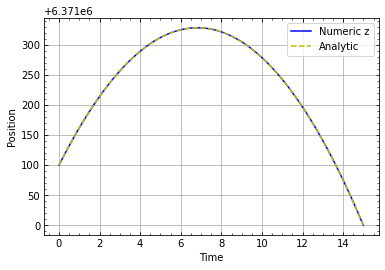

In [9]:
# TEST CASE 1
def tc1_gamma(x, y, z) :
    '''
    This is an idealized gamma function where gamma is 0 everywhere
    This is only used for Test Case 1
    '''
    return 0
max_nodes=40000
m = 1
d = .01
zo = r_earth + 100
zf = r_earth
omega = np.array([0, 0, 0])

ibc = np.array([0, 0, zo])
fbc = np.array([0, 0, zf])
T=15
t = np.linspace(0, T, 1000)
pos = np.ones([6, len(t)]) 
pos[0,:]=np.linspace(ibc[0],fbc[0],len(t))
pos[1,:]=np.linspace(ibc[1],fbc[1],len(t))
pos[2,:]=np.linspace(ibc[2],fbc[2],len(t))
pos[3,:]=pos[3,:]*0
pos[4,:]=pos[4,:]*0
pos[5,:]=pos[5,:]*10
# (sol, x, y, yp, rms_resid, niter, status, message, success)
ans = integ.solve_bvp(lambda x, y : ddt_fun(x, y, omega, tc1_gamma, m, d), 
                        lambda ya, yb : bc(ya, yb, ibc, fbc), t, pos, verbose = 2,
                        fun_jac = lambda x, y : Jacobian(x, y, omega,tc1_gamma, d, m, g),max_nodes=max_nodes,
                        bc_jac=bc_jac)
plt.plot(ans.x, ans.y[2], c = 'b', label = 'Numeric z')
tc1_z = -g * ans.x**2 / 2 +  ((zf - zo + (g * T**2 / 2)) / T) * ans.x + zo
plt.plot(ans.x, tc1_z, c = 'y', label = 'Analytic', ls = '--')
plt.legend()
plt.grid()
plt.xlabel('Time')
plt.ylabel('Position')

## Free Fall with air resistance
Set a boundary condition up in the air in the z axis: Initial $\textbf{R(t=0)}={0,0,z_1}$, Final $\textbf{R(t=T)}={0,0,z_2}$ such that there is only movement in the z direction.  If we assume $\Omega=0$ the ball should simply travel downwards to $z_2$ satisfying $z_1>z_2$.  We will assume $\gamma$ is a constant.
Thus, the EOM for this system is:
$$\ddot{z}=-g-\gamma \frac{D^2}{m}\dot{z}
$$
The solution to this equation is:
$$z(t)=-\frac{m g t}{\gamma D^2}-C_1 \frac{m}{\gamma D^2}e^{-t \gamma \frac{D^2}{m}}+C_2
$$
We can write these in terms of $T$ and $z_1$ and $z_2$ satisfying $z_1>z_2$ as described by our boundary conditions:
$$z(t)=-\frac{m g t}{\gamma D^2}- 
\left( \frac{(gmT+D^2 \gamma(z_2-z_1))}{D^2\gamma (e^{\frac{D^2 T \gamma}{m}}-1)} \right) 
e^{(T-t)\gamma \frac{D^2}{m}}
+\frac{-D^2 z_1 \gamma+e^{\frac{D^2 T \gamma}{m}}(g m T+D^2 z_2 \gamma)}{D^2\gamma(e^{\frac{D^2 T \gamma}{m}}-1)}
$$
This same analysis and result is not only in the z direction, since Cartesian coordinates are arbitrary.  So we can just replace all the $z$'s above with $x$'s or $y$'s.



# Test Case 2

In [10]:
# TEST CASE 2
def gamma2(x, y, z) :
    '''
    This is an idealized constant gamma function where gamma is a nonzero constant everywhere
    Inside of the Earth gamma is extremely large to make the ball not want to travel into the Earth's surface
    '''
    if (la.norm(np.array([x,y,z]),axis=0)>r_earth):
        return 0.0001
    else :
        return 10000000
tc2_gamma = np.vectorize(gamma2)
max_nodes=40000
T=16
tc2_t = np.linspace(0, T, 1000)
tc2_zo = r_earth + 100
tc2_zf = r_earth + 1
ibc = np.array([0, 0, tc2_zo])
fbc = np.array([0, 0, tc2_zf])
tc2_omega = np.array([0, 0, 0])
tc2_m = 1
tc2_d = 0.1
pos = np.ones([6, len(t)]) 

pos[0,:]=np.linspace(ibc[0],fbc[0],len(t))
pos[1,:]=np.linspace(ibc[1],fbc[1],len(t))
pos[2,:]=np.linspace(ibc[2],fbc[2],len(t))
pos[3,:]=pos[3,:]*0
pos[4,:]=pos[4,:]*0
pos[5,:]=pos[5,:]*10
# (sol, p, x, y, yp, rms_resid, niter, status, message, success)
ans2 = integ.solve_bvp(lambda x, y : ddt_fun(x, y, tc2_omega, tc2_gamma, tc2_m, tc2_d), 
                        lambda ya, yb : bc(ya, yb, ibc, fbc), tc2_t, pos, verbose = 2,
                        fun_jac = lambda x, y : Jacobian(x, y, tc2_omega,tc2_gamma, tc2_d, tc2_m, g),max_nodes=max_nodes,
                        bc_jac=bc_jac)

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          2.63e+02       4.44e+01         1000             2       
       2          4.77e-06       4.25e-05         1002             0       
Solved in 2 iterations, number of nodes 1002. 
Maximum relative residual: 4.77e-06 
Maximum boundary residual: 4.25e-05


Text(0, 0.5, 'Position')

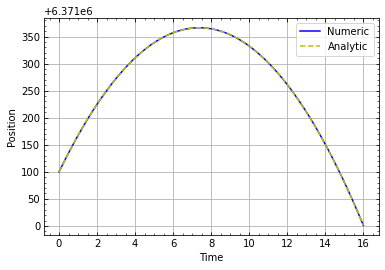

In [11]:
plt.plot(ans2.x, ans2.y[2], c = 'b', label = 'Numeric')
gam=tc2_gamma(r_earth,r_earth,r_earth)
term1 = tc2_m * g * ans2.x / (gam * tc2_d**2)
term2 = (g * tc2_m * T + (tc2_d**2 * gam * (tc2_zf - tc2_zo))) / ((tc2_d**2 * gam) * (np.exp(T * gam * tc2_d**2 / tc2_m) - 1))
term3 = (-tc2_d**2 * tc2_zo * gam + np.exp(T * gam * tc2_d**2 / tc2_m) * (g * tc2_m * T + tc2_d**2 * tc2_zf * gam)) / (tc2_d**2 * gam * (np.exp(T * gam * tc2_d**2 / tc2_m) - 1))
tc2_z = -term1 - term2*np.exp((T-ans2.x)*gam*tc2_d**2/tc2_m) + term3

plt.plot(ans2.x, tc2_z, c = 'y', label = 'Analytic', ls = '--')
plt.legend()
plt.grid()
plt.xlabel('Time')
plt.ylabel('Position')

### Motion with $\Omega=\hat{z}$
Set a boundary condition up in the air in the z axis: Initial $\textbf{R(t=0)}={x_0,y_0,0}$, Final $\textbf{R(t=T)}={x_1,y_1,0}$ such that there is movement on the xy plane.  If we assume $\Omega=\hat{z}$ the ball should rotate around the z axis.  We will assume $\gamma$ is zero and gravity is 0.
Thus, the EOM for this system is:
$$\ddot{x}=2\dot{y}+x
$$
and 
$$\ddot{y}=-2\dot{x}+y
$$
The solutions to these equatins are:
$$x(t)=(C_1+t(C_2-C_3))\cos{t}+(C_3+t(C_1+C_4))\sin{t}
$$
and
$$y(t)=(C_3+t(C_1+C_4))\cos{t}-(C_1+t(C_2-C_3))\sin{t}
$$
We can write these in terms of $T$ and the 4 boundary conditions:
$$x(t)=\frac{-(t-T)\cos{(t)}x_0+t\cos{(t-T)}x_1-t\sin{(t)}y_0+T\sin{(t)}y_0+t\sin{(t-T)}y_1}{T}
$$
and
$$y(t)=\frac{(t-T)\sin{(t)}x_0-t\sin{(t-T)}x_1-t\cos{(t)}y_0+T\cos{(t)}y_0+t\cos{(t-T)}y_1}{T}
$$
This same analysis and result is not only in the z direction, since Cartesian coordinates are arbitrary.  So we can just replace all the $z$'s above with $x$'s or $y$'s.

# Test Case 3

In [12]:
def ddt_fun_0g (t, pos, Omega, gamma, m, D) :
    """
    Returns dpdt, the derivatives of the position usable by solve_bvp.
    Calculates the derivatives of pos where
    
    pos[0] = x
    pos[1] = y
    pos[2] = x
    pos[3] = dx/dt
    pos[4] = dy/dt
    pos[5] = dz/dt
    
    Omega[0] = x value of the spin of the Earth
    Omega[1] = y value of the spin of the Earth
    Omega[2] = z value of the spin of the Earth
    
    p_0 = equivalent to "T" a convenient term used for parameterization
    gamma = term used to describe air resistance's effects against motion
    D = diameter of spherical ball
    m = mass of object
    ===============
    dpdt, a matrix the same size as pos, containing the first and
    second derivatives of pos
    dpdt[0] = dx/dTau
    dpdt[1] = dy/dTau
    dpdt[2] = dz/dTau
    dpdt[3] = dx^2/d^2Tau
    dpdt[4] = dy^2/d^2Tau
    dpdt[5] = dz^2/d^2Tau
    """
    dpdt = np.zeros_like(pos)
    
    # define some useful values
    frac = - 0 / np.sqrt(pos[0]**2 + pos[1]**2 + pos[2]**2)
    last_term = gamma(pos[0], pos[1], pos[2]) * D**2 / m * np.sqrt(pos[3]**2 + pos[4]**2 + pos[5]**2)
    
    dpdt[:3] = pos[3:]
    dpdt[3] = ( frac*pos[0]  + 2*( pos[4]*Omega[2] - pos[5]*Omega[1] )  + Omega[2]*( Omega[2]*pos[0] - Omega[0]*pos[2] )  - Omega[1]*( Omega[0]*pos[1] - Omega[1]*pos[0] )  - pos[3]*last_term )
    dpdt[4] = ( frac*pos[1]  + 2*( pos[5]*Omega[0] - pos[3]*Omega[2] )  + Omega[0]*( Omega[0]*pos[1] - Omega[1]*pos[0] )  - Omega[2]*( Omega[1]*pos[2] - Omega[2]*pos[1] )  - pos[4]*last_term )
    dpdt[5] = ( frac*pos[2]  + 2*( pos[3]*Omega[1] - pos[4]*Omega[0] )  + Omega[1]*( Omega[1]*pos[2] - Omega[2]*pos[1] )  - Omega[0]*( Omega[2]*pos[0] - Omega[0]*pos[2] )  - pos[5]*last_term )
    
    return dpdt

In [14]:
# TEST CASE 3
def gamma3(x, y, z) :
    if (la.norm(np.array([x,y,z]),axis=0)>r_earth):
        return 0
    else :
        return 10000000
tc3_gamma = np.vectorize(gamma3)
T=0.9
t = np.linspace(0, T, 1000)
tc3_xo = r_earth
tc3_yo = 999*r_earth/1000
tc3_xf = 999*r_earth/1000
tc3_yf = r_earth
tc3_omega = np.array([0, 0, 1])
tc3_m = 1
tc3_d = 1
tc3_t = np.linspace(0, 1, 1000)
tc3_pos = np.ones([6, len(t)]) 
tc3_pos[0,:]=np.linspace(tc3_xo,tc3_xf,len(t))
tc3_pos[1,:]=np.linspace(tc3_yo,tc3_yf,len(t))

tc3_pos[2,:]=tc3_pos[2,:]*0
tc3_pos[3:5,:]=tc3_pos[3:4,:]*1
tc3_pos[-1,:]=tc3_pos[-1,:]*0
ibc = np.array([tc3_xo, tc3_yo, 0])
fbc = np.array([tc3_xf, tc3_yf, 0])
max_nodes=800000
# (sol, p, x, y, yp, rms_resid, niter, status, message, success)
ans3 = integ.solve_bvp(lambda x, y : ddt_fun(x, y, tc3_omega, tc3_gamma, tc3_m, tc3_d), 
                        lambda ya, yb : bc(ya, yb, ibc, fbc), t, tc3_pos, verbose = 2,
                        fun_jac = lambda x, y : Jacobian(x, y, tc3_omega,tc3_gamma, tc3_d, tc3_m, g),max_nodes=max_nodes,
                        bc_jac=bc_jac)

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          2.60e-06       1.24e+05         1000             0       
       2          7.82e-07       6.76e+03         1000             0       
       3          2.39e-06       2.89e+02         1000             0       
       4          4.59e-07       9.77e+00         1000             0       
       5          4.25e-07       4.73e-01         1000             0       
       6          4.25e-07       2.20e-02         1000             0       
       7          4.25e-07       8.20e-04         1000             0       
Solved in 7 iterations, number of nodes 1000. 
Maximum relative residual: 4.25e-07 
Maximum boundary residual: 8.20e-04


Text(0, 0.5, 'x-Position')

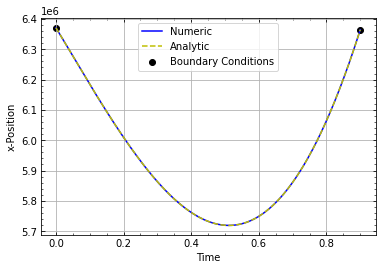

In [15]:
# PLOT X FOR TC3
tc3x_term1 = (ans3.x - T)*np.cos(ans3.x)*tc3_xo
tc3x_term2 = ans3.x*np.cos(ans3.x - T)*tc3_xf
tc3x_term34 = (T - ans3.x)*np.sin(ans3.x)*tc3_yo
tc3x_term5 = ans3.x*np.sin(ans3.x - T)*tc3_yf

tc3_analytic = ( -tc3x_term1 + tc3x_term2 + tc3x_term34 + tc3x_term5 )/T

plt.plot(ans3.x, ans3.y[0], color = 'b', label = 'Numeric')
plt.plot(ans3.x, tc3_analytic, color = 'y', ls = '--', label = 'Analytic')
actual = np.array([tc3_xo, tc3_xf])
plt.scatter(np.array([0, ans3.x[-1]]), actual, color = 'black', label = 'Boundary Conditions')
plt.legend()
plt.grid()
plt.xlabel('Time')
plt.ylabel('x-Position')

8106973.438503965
6371000.0


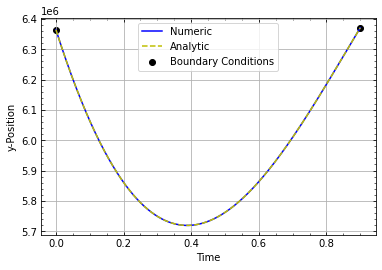

In [16]:
tc3y_term1 = (ans3.x - T)*np.sin(ans3.x)*tc3_xo
tc3y_term2 = ans3.x*np.sin(ans3.x - T)*tc3_xf
tc3y_term34 = (T - ans3.x)*np.cos(ans3.x)*tc3_yo
tc3y_term5 = ans3.x*np.cos(ans3.x - T)*tc3_yf

tc3y_analytic = ( tc3y_term1 - tc3y_term2 + tc3y_term34 + tc3y_term5) / T

plt.plot(ans3.x, ans3.y[1], color = 'b', label = 'Numeric')
actual = np.array([tc3_yo, tc3_yf])
plt.plot(ans3.x, tc3y_analytic, color = 'y', ls = '--', label = 'Analytic')
plt.scatter(np.array([0, ans3.x[-1]]), actual, color = 'black', label = 'Boundary Conditions')
plt.legend()
plt.grid()
plt.xlabel('Time')
plt.ylabel('y-Position')
print(min(la.norm(np.array([ans3.y[1],ans3.y[0],ans3.y[2]]),axis=0)))
print(r_earth)

### Real Test

In [17]:
def real_test() :
    '''
    This is our first working real test case for solve_bvp.  We wanted the ball to fall in all 3 dimensions with all the forces acting on it at once
    This is self contained and has no outputs other than the verbose output of solve_bvp to prove that our function operates correctly
    We do not recomend runnign this cell, but are keeping it for our presentation
    '''
    T=18.305
    t = np.linspace(0, T, 1000)
    omega=s2cart1(2*np.pi/(3600*24), 72.68, 80.65)
    m = 1
    d = 0.05
    max_nodes=1000000
    ibc = np.array([r_earth/np.sqrt(2)+1, r_earth/np.sqrt(2)+1, 0])
    fbc = np.array([r_earth/np.sqrt(2)+151, r_earth/np.sqrt(2)-50, 10])
    pos = np.ones([6, len(t)]) 
    pos[0,:] = path_guess(t, ibc[0], fbc[0], g)
    pos[1,:] = path_guess(t, ibc[1], fbc[1], g)
    pos[2,:] = path_guess(t, ibc[2], fbc[2], g)
    pos[3,:] = velocity_guess(t, ibc[0], fbc[0], g)
    pos[4,:] = velocity_guess(t, ibc[1], fbc[1], g)
    pos[5,:] = velocity_guess(t, ibc[2], fbc[2], g)

    # (sol, p, x, y, yp, rms_resid, niter, status, message, success)
    ans = integ.solve_bvp(lambda x, y : ddt_fun(x, y, omega, gamma_real, m, d), 
                            lambda ya, yb : bc(ya, yb, ibc, fbc), t, pos, verbose = 2,
                            fun_jac = lambda x, y : Jacobian(x, y, omega,gamma_real, d, m, g),max_nodes=max_nodes,
                            bc_jac=bc_jac)
    plt.plot(ans.x, ans.y[2], c = 'r', label = 'Numeric z')
    plt.plot(ans.x, ans.y[1], c = 'y', label = 'Numeric y')
    plt.plot(ans.x, ans.y[0], c = 'b', label = 'Numeric x')
    plt.legend()
    plt.grid()
    plt.xlabel('Time')
    plt.ylabel('Position')
    return
# real_test()
# We commented this out since it takes 4 hours to run, but does eventually give back the correct solution

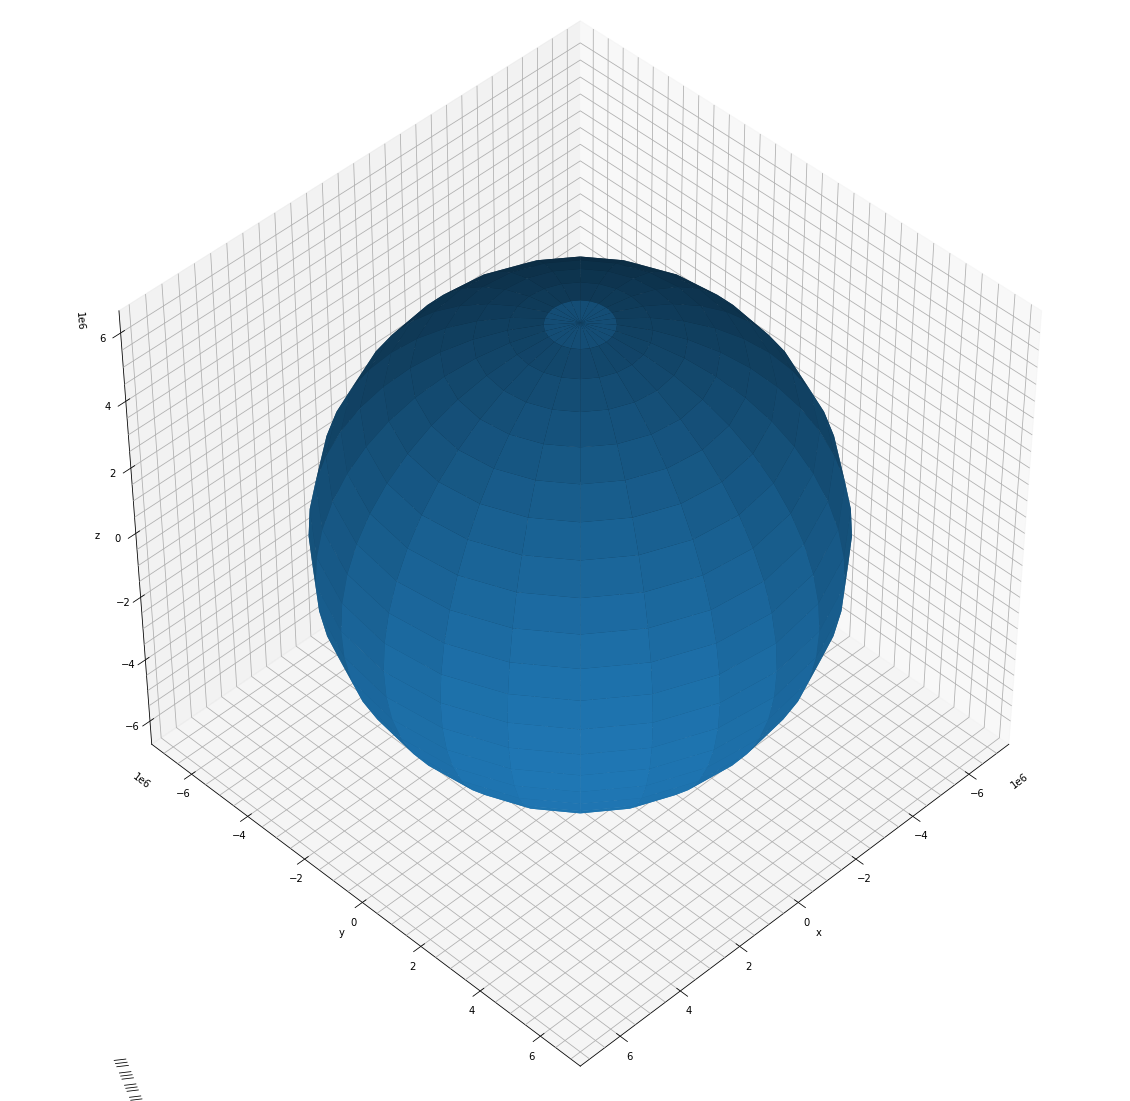

In [62]:
e_angle1 = np.linspace(0, 2*np.pi, 25) # phi
e_angle2 = np.linspace(0, np.pi, 25) # theta
e_RADIUS = r_earth
e_ANGLE1, e_ANGLE2 = np.meshgrid(e_angle1, e_angle2)
e_X = e_RADIUS * np.sin(e_ANGLE2) * np.cos(e_ANGLE1)
e_Y = e_RADIUS * np.sin(e_ANGLE2) * np.sin(e_ANGLE1)
e_Z = e_RADIUS * np.cos(e_ANGLE2)

fig = plt.figure(figsize = (20, 20))
ax = fig.add_subplot(111, projection = '3d')
globe = ax.plot_surface(e_X, e_Y, e_Z, rstride=1, cstride=1) #, linewidth=0, antialiased=False, alpha=0.5)
# EARTH
#x = ax.plot3D(e_X, np.zeros_like(e_X), np.zeros_like(e_X))

path = ax.plot(ans.y[0], ans.y[1], ans.y[2], c = 'r', linewidth = 5)

ax.set_ylabel('y')
ax.set_xlabel('x')
ax.set_zlabel('z')

# grounding frame
low = -6.5e6
high = 0
ax.plot(np.linspace(low, high, 2), np.ones(2)*low, np.ones(2)*low, c = 'black')
ax.plot(np.ones(2)*low, np.linspace(low, high, 2), np.ones(2)*low, c = 'black')
ax.plot(np.ones(2)*low, np.ones(2)*low, np.linspace(low, high, 2), c = 'black')

#for angle in range(0, 360):
    #ax.view_init(30, angle)
    #plt.draw()
    #plt.pause(.001)

rot = 45
elev = 45

ax.view_init(elev = elev, azim = rot)

b = -154.93364163698283 +/- 19.291829461928476
m = 65.65114796483428 +/- 3.194847966157735


Text(0, 0.5, 'Distance')

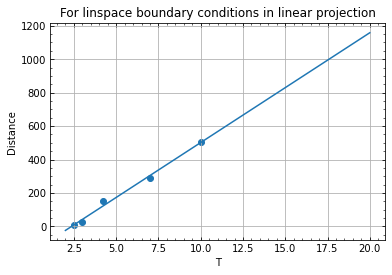

In [19]:
def fit(x, a, b) :
    return a*x + b


Tarr = np.array([2.5, 3, 4.25, 7, 10])
Xarr = np.array([10, 24.5, 151, 291.9, 504.1])

plt.scatter(Tarr, Xarr)
plt.grid()
plt.title('For linspace boundary conditions in linear projection')
popt, pcov = opt.curve_fit(fit, Tarr, Xarr)
xd = np.linspace(2, 20, 1000)
plt.plot(xd, fit(xd, popt[0], popt[1]))


print("b =", popt[1], "+/-", (pcov[1,1]**0.5))
print("m =", popt[0], "+/-", (pcov[0,0]**0.5))
plt.xlabel("T")
plt.ylabel("Distance")

# "Recursive" Test Cases

In [59]:
def mass4thing() :
    '''
    This is our test case for a 4.5 kg ball with a 5 cm diameter thrown equatorially. This function falls under the category of a test function. 
    '''
    T = 0.5
    t = np.linspace(0, T, 1000)
    omega=s2cart1(2*np.pi/(3600*24), 72.68, 80.65)
    m = 4.5
    d = 0.05
    max_nodes=1000000
    ibc = s2cart(r_earth, np.pi/2, 0)
    fbc = s2cart(r_earth, np.pi/2, 0.000001)
    pos = np.ones([6, len(t)]) 
    pos[0,:] = path_guess(t, ibc[0], fbc[0], g)
    pos[1,:] = path_guess(t, ibc[1], fbc[1], g)
    pos[2,:] = path_guess(t, ibc[2], fbc[2], g)
    pos[3,:] = velocity_guess(t, ibc[0], fbc[0], g)
    pos[4,:] = velocity_guess(t, ibc[1], fbc[1], g)
    pos[5,:] = velocity_guess(t, ibc[2], fbc[2], g)
    ans = integ.solve_bvp(lambda x, y : ddt_fun(x, y, omega, gamma_real, m, d), 
                            lambda ya, yb : bc(ya, yb, ibc, fbc), t, pos, verbose = 2, bc_jac=bc_jac,
                            max_nodes=max_nodes, fun_jac = lambda x, y : Jacobian(x, y, omega,gamma_real, d, m, g))

    T = 0.9
    t = T*ans.x[::]/0.5
    max_nodes=1000000
    ibc = s2cart(r_earth, np.pi/2, 0)
    fbc = s2cart(r_earth, np.pi/2, 0.00001)
    pos = np.ones([6, len(t)]) 
    pos = ans.y[:,:]
    ans = integ.solve_bvp(lambda x, y : ddt_fun(x, y, omega, gamma_real, m, d), 
                            lambda ya, yb : bc(ya, yb, ibc, fbc), t, pos, verbose = 2, bc_jac=bc_jac,
                            max_nodes=max_nodes, fun_jac = lambda x, y : Jacobian(x, y, omega,gamma_real, d, m, g))

    T = 2
    t = T*ans.x[:]/0.9
    max_nodes=1000000
    ibc = s2cart(r_earth, np.pi/2, 0)
    fbc = s2cart(r_earth, np.pi/2, 0.0001)
    pos = np.ones([6, len(t)]) 
    pos = ans.y
    ans = integ.solve_bvp(lambda x, y : ddt_fun(x, y, omega, gamma_real, m, d), 
                            lambda ya, yb : bc(ya, yb, ibc, fbc), t, pos, verbose = 2, bc_jac=bc_jac,
                            max_nodes=max_nodes, fun_jac = lambda x, y : Jacobian(x, y, omega,gamma_real, d, m, g))

    T = 3
    t = T*ans.x[:]/2
    max_nodes=2000000
    ibc = s2cart(r_earth, np.pi/2, 0)
    fbc = s2cart(r_earth, np.pi/2, 0.00075)
    pos = np.ones([6, len(t)]) 
    pos = ans.y[:,:]
    ans = integ.solve_bvp(lambda x, y : ddt_fun(x, y, omega, gamma_real, m, d), 
                            lambda ya, yb : bc(ya, yb, ibc, fbc), t, pos, verbose = 2, bc_jac=bc_jac,
                            max_nodes=max_nodes, fun_jac = lambda x, y : Jacobian(x, y, omega,gamma_real, d, m, g))

    T = 3.5
    t = T*ans.x[::3]/3
    max_nodes=2000000
    ibc = s2cart(r_earth, np.pi/2, 0)
    fbc = s2cart(r_earth, np.pi/2, 0.00095)
    pos = np.ones([6, len(t)]) 
    pos = ans.y[:,::3]
    ans = integ.solve_bvp(lambda x, y : ddt_fun(x, y, omega, gamma_real, m, d), 
                            lambda ya, yb : bc(ya, yb, ibc, fbc), t, pos, verbose = 2, bc_jac=bc_jac,
                            max_nodes=max_nodes, fun_jac = lambda x, y : Jacobian(x, y, omega,gamma_real, d, m, g))

    T = 3.75
    t = T*ans.x[::15]/3.5
    max_nodes=2000000
    ibc = s2cart(r_earth, np.pi/2, 0)
    fbc = s2cart(r_earth, np.pi/2, 0.001) #0.00157 -> 10,000 km
    pos = np.ones([6, len(t)]) 
    pos = ans.y[:,::15]
    ans = integ.solve_bvp(lambda x, y : ddt_fun(x, y, omega, gamma_real, m, d), 
                            lambda ya, yb : bc(ya, yb, ibc, fbc), t, pos, verbose = 2, bc_jac=bc_jac,
                            max_nodes=max_nodes, fun_jac = lambda x, y : Jacobian(x, y, omega,gamma_real, d, m, g))

    T = 4.25
    t = T*ans.x[::10]/3.75
    max_nodes=2000000
    ibc = s2cart(r_earth, np.pi/2, 0)
    fbc = s2cart(r_earth, np.pi/2, 0.0012) #0.00157 -> 10,000 km
    pos = np.ones([6, len(t)]) 
    
    pos = ans.y[:,::10]
    ans = integ.solve_bvp(lambda x, y : ddt_fun(x, y, omega, gamma_real, m, d), 
                            lambda ya, yb : bc(ya, yb, ibc, fbc), t, pos, verbose = 2, bc_jac=bc_jac,
                            max_nodes=max_nodes, fun_jac = lambda x, y : Jacobian(x, y, omega,gamma_real, d, m, g))

    T = 5
    t = T*ans.x[::10]/4.25
    max_nodes=2000000
    ibc = s2cart(r_earth, np.pi/2, 0)
    fbc = s2cart(r_earth, np.pi/2, 0.00157) #0.00157 -> 10,000 km
    pos = np.ones([6, len(t)]) 
    pos = ans.y[:,::10]
    ans = integ.solve_bvp(lambda x, y : ddt_fun(x, y, omega, gamma_real, m, d), 
                            lambda ya, yb : bc(ya, yb, ibc, fbc), t, pos, verbose = 2, bc_jac=bc_jac,
                            max_nodes=max_nodes, fun_jac = lambda x, y : Jacobian(x, y, omega,gamma_real, d, m, g))

    T = 6
    t = T*ans.x[:]/5
    max_nodes=2000000
    ibc = s2cart(r_earth, np.pi/2, 0)
    fbc = s2cart(r_earth, np.pi/2, 0.00175) #0.00157 -> 10,000 km
    pos = np.ones([6, len(t)]) 
    pos = ans.y[:,:]
    ans = integ.solve_bvp(lambda x, y : ddt_fun(x, y, omega, gamma_real, m, d), 
                            lambda ya, yb : bc(ya, yb, ibc, fbc), t, pos, verbose = 2, bc_jac=bc_jac,
                            max_nodes=max_nodes, fun_jac = lambda x, y : Jacobian(x, y, omega,gamma_real, d, m, g))
    
    return ans

In [21]:
#mass4thing() # This cell will take awhile to run...like a really long time...

In [22]:
# Rockefeller
# 41.503751,-81.608217
# r_earth + 199 m
rock_xyz = s2cart(r_earth + 199, np.deg2rad(41.503751), np.deg2rad(-81.608217))

# Edgewater Park Pokemon Arena
# 41.490004,-81.736639
# r_earth + 174 m
park_xyz = s2cart(r_earth + 174, np.deg2rad(41.490004), np.deg2rad(-81.736639))


In [58]:
def fun_solver() :
    '''
    This is the function we use to solve our problem. We take a 6 kg pokeball and throw it further and further, using our previous results as guesses for an increased distance. 
    This function returns the solve_bvp object for our final distance as well as the initial and final boundary conditions so our plotting function can plot those points. 
    '''
    T = 0.5
    t = np.linspace(0, T, 1000)
    omega=s2cart1(2*np.pi/(3600*24), 72.68, 80.65)
    m = 6
    d = 0.048
    max_nodes=1000000
    ibc = rock_xyz
    fbc = s2cart(r_earth + 199, np.deg2rad(41.503768), np.deg2rad(-81.608343))#6.3m
    pos = np.ones([6, len(t)]) 
    pos[0,:] = path_guess(t, ibc[0], fbc[0], g)
    pos[1,:] = path_guess(t, ibc[1], fbc[1], g)
    pos[2,:] = path_guess(t, ibc[2], fbc[2], g)
    pos[3,:] = velocity_guess(t, ibc[0], fbc[0], g)
    pos[4,:] = velocity_guess(t, ibc[1], fbc[1], g)
    pos[5,:] = velocity_guess(t, ibc[2], fbc[2], g)
    ans = integ.solve_bvp(lambda x, y : ddt_fun(x, y, omega, gamma_real, m, d), 
                            lambda ya, yb : bc(ya, yb, ibc, fbc), t, pos, verbose = 1, bc_jac=bc_jac,
                            max_nodes=max_nodes, fun_jac = lambda x, y : Jacobian(x, y, omega,gamma_real, d, m, g))
    print('\nUsing answer to guess for 63 m...')
    T = 0.9
    t = T*ans.x[::]/0.5
    max_nodes=1000000
    fbc = s2cart(r_earth + 199, np.deg2rad(41.503691), np.deg2rad(-81.608907))#63m
    pos = np.ones([6, len(t)]) 
    pos = ans.y[:,:]
    ans = integ.solve_bvp(lambda x, y : ddt_fun(x, y, omega, gamma_real, m, d), 
                            lambda ya, yb : bc(ya, yb, ibc, fbc), t, pos, verbose = 1, bc_jac=bc_jac,
                            max_nodes=max_nodes, fun_jac = lambda x, y : Jacobian(x, y, omega,gamma_real, d, m, g))
    print('\nUsing answer to guess for 630 m...')
    T = 2
    t = T*ans.x[:]/0.9
    max_nodes=1000000
    fbc = s2cart(r_earth + 199, np.deg2rad(41.502980), np.deg2rad(-81.615730))#630m
    pos = np.ones([6, len(t)]) 
    pos = ans.y
    ans = integ.solve_bvp(lambda x, y : ddt_fun(x, y, omega, gamma_real, m, d), 
                            lambda ya, yb : bc(ya, yb, ibc, fbc), t, pos, verbose = 1, bc_jac=bc_jac,
                            max_nodes=max_nodes, fun_jac = lambda x, y : Jacobian(x, y, omega,gamma_real, d, m, g))
    print('\nUsing answer to guess for 4800 m...')
    # 41.497585,-81.665254
    T= 2.5
    t = T*ans.x[:]/2
    max_nodes=2000000
    fbc = s2cart(r_earth + 199, np.deg2rad(41.497585), np.deg2rad(-81.665254))#4800m
    pos = np.ones([6, len(t)]) 
    pos = ans.y[:,:]
    ans = integ.solve_bvp(lambda x, y : ddt_fun(x, y, omega, gamma_real, m, d), 
                            lambda ya, yb : bc(ya, yb, ibc, fbc), t, pos, verbose = 1, bc_jac=bc_jac,
                            max_nodes=max_nodes, fun_jac = lambda x, y : Jacobian(x, y, omega,gamma_real, d, m, g))
    print('\nUsing answer to guess for 6000 m...')
    # 41.496057,-81.679646
    T = 3.2
    t = T*ans.x[::3]/2.5
    max_nodes=2000000
    fbc = s2cart(r_earth + 199, np.deg2rad(41.496057), np.deg2rad(-81.679646))#6000m
    pos = np.ones([6, len(t)]) 
    pos = ans.y[:,::3]
    ans = integ.solve_bvp(lambda x, y : ddt_fun(x, y, omega, gamma_real, m, d), 
                            lambda ya, yb : bc(ya, yb, ibc, fbc), t, pos, verbose = 1, bc_jac=bc_jac,
                            max_nodes=max_nodes, fun_jac = lambda x, y : Jacobian(x, y, omega,gamma_real, d, m, g))
    print('\nUsing answer to guess for 6300 m...')
    # 41.495679,-81.682975
    T = 3.5
    t = T*ans.x[:]/3.2
    max_nodes=2000000
    fbc = s2cart(r_earth + 199, np.deg2rad(41.495679), np.deg2rad(-81.682975))#6300m
    pos = np.ones([6, len(t)]) 
    pos = ans.y[:,:]
    ans = integ.solve_bvp(lambda x, y : ddt_fun(x, y, omega, gamma_real, m, d), 
                            lambda ya, yb : bc(ya, yb, ibc, fbc), t, pos, verbose = 1, bc_jac=bc_jac,
                            max_nodes=max_nodes, fun_jac = lambda x, y : Jacobian(x, y, omega,gamma_real, d, m, g))
    print('\nUsing answer to guess for 7600 m...')
    # 41.494070,-81.698414
    T = 3.9
    t = T*ans.x[:]/3.5
    max_nodes=2000000
    fbc = s2cart(r_earth + 199, np.deg2rad(41.494070), np.deg2rad(-81.698414)) #7600m
    pos = np.ones([6, len(t)])
    pos = ans.y[:,:]
    ans = integ.solve_bvp(lambda x, y : ddt_fun(x, y, omega, gamma_real, m, d), 
                            lambda ya, yb : bc(ya, yb, ibc, fbc), t, pos, verbose = 1, bc_jac=bc_jac,
                            max_nodes=max_nodes, fun_jac = lambda x, y : Jacobian(x, y, omega,gamma_real, d, m, g))
    print('\nUsing answer to guess for final distance with no radius change...')
    T = 4.1
    t = T*ans.x[::10]/3.9
    max_nodes=2000000
    ibc = rock_xyz
    fbc = s2cart(r_earth + 199, np.deg2rad(41.490004), np.deg2rad(-81.736639)) #0.00157 -> 10,000 km
    pos = np.ones([6, len(t)]) 
    pos = ans.y[:,::10]
    ans = integ.solve_bvp(lambda x, y : ddt_fun(x, y, omega, gamma_real, m, d), 
                            lambda ya, yb : bc(ya, yb, ibc, fbc), t, pos, verbose = 1, bc_jac=bc_jac,
                            max_nodes=max_nodes, fun_jac = lambda x, y : Jacobian(x, y, omega,gamma_real, d, m, g))
    print('\nUsing answer to actually solve the problem...')

    T = 4.1
    t = T*ans.x[::5]/4.1
    max_nodes=2000000
    ibc = rock_xyz
    fbc = park_xyz #0.00157 -> 10,000 km
    pos = np.ones([6, len(t)]) 
    pos = ans.y[:,::5]
    ans = integ.solve_bvp(lambda x, y : ddt_fun(x, y, omega, gamma_real, m, d), 
                            lambda ya, yb : bc(ya, yb, ibc, fbc), t, pos, verbose = 2, bc_jac=bc_jac,
                            max_nodes=max_nodes, fun_jac = lambda x, y : Jacobian(x, y, omega,gamma_real, d, m, g))
    return ans, ibc, fbc

In [24]:
ans_real, ibc, fbc = fun_solver()

Solved in 2 iterations, number of nodes 1000. 
Maximum relative residual: 9.86e-07 
Maximum boundary residual: 9.88e-04

Using answer to guess for 63 m...
Solved in 1 iterations, number of nodes 1000. 
Maximum relative residual: 4.25e-06 
Maximum boundary residual: 2.79e-04

Using answer to guess for 630 m...
Solved in 1 iterations, number of nodes 1000. 
Maximum relative residual: 1.36e-07 
Maximum boundary residual: 7.12e-04

Using answer to guess for 4800 m...
Solved in 5 iterations, number of nodes 7993. 
Maximum relative residual: 2.59e-05 
Maximum boundary residual: 6.61e-04

Using answer to guess for 6000 m...
Solved in 3 iterations, number of nodes 5329. 
Maximum relative residual: 9.59e-08 
Maximum boundary residual: 9.47e-04

Using answer to guess for 6300 m...
Solved in 3 iterations, number of nodes 10657. 
Maximum relative residual: 1.33e-07 
Maximum boundary residual: 3.16e-04

Using answer to guess for 7600 m...
Solved in 8 iterations, number of nodes 85249. 
Maximum rela

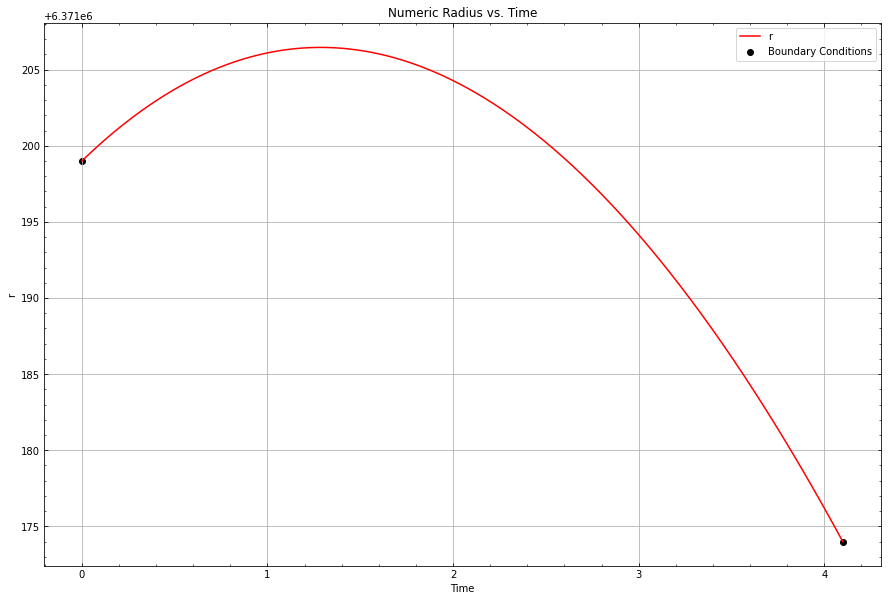

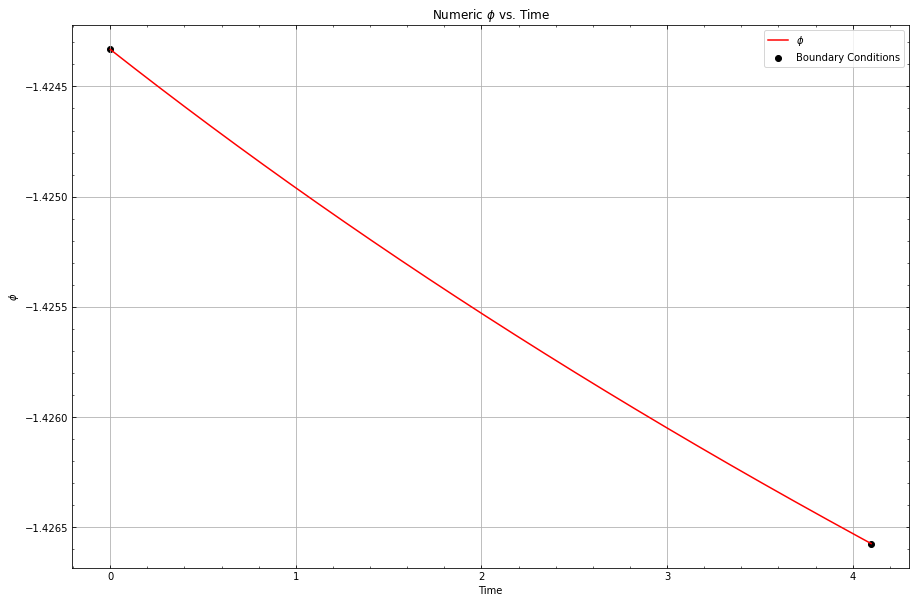

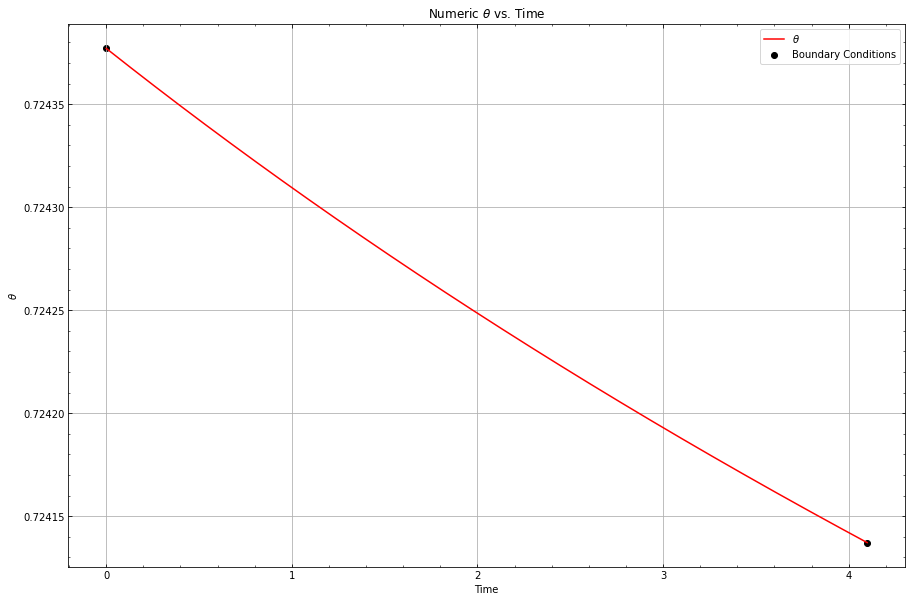

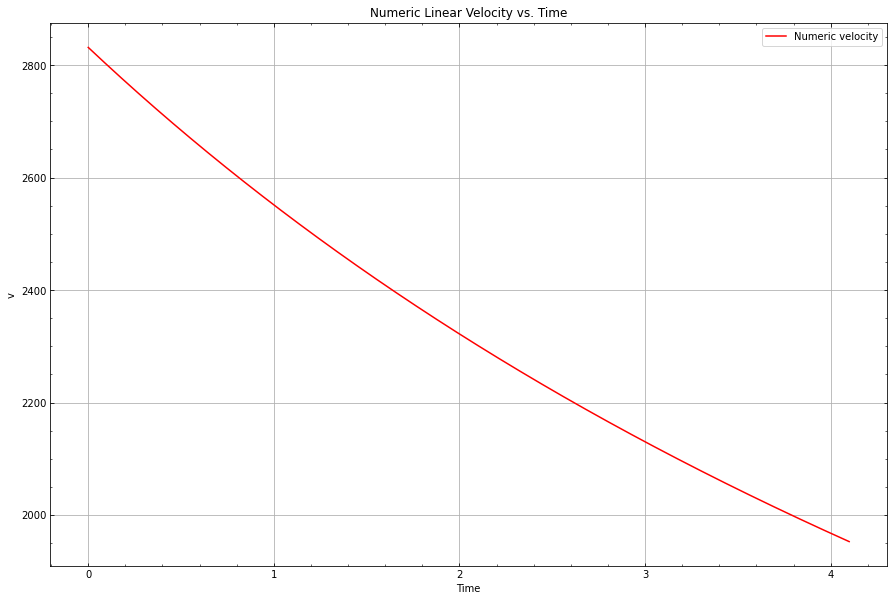

In [28]:
plot_bvp_obj(ans_real, ibc, fbc)

These are our original graphs which we realized are not super helpful, so we converted to the spherical graphs as shown above


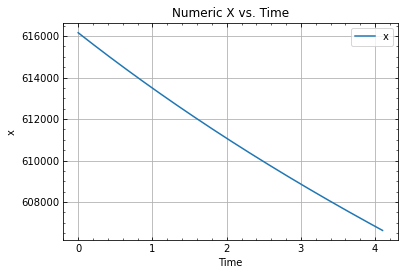

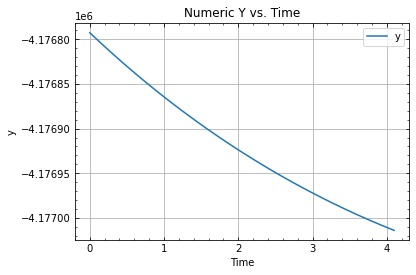

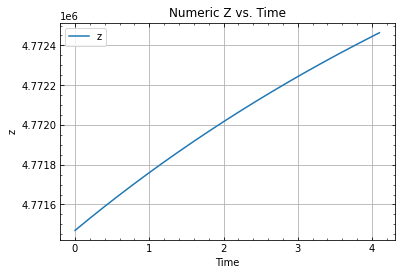

In [57]:
print('These are our original graphs which we realized are not super helpful, so we converted to the spherical graphs as shown above')
plt.plot(ans_real.x, ans_real.y[0], label = 'x')
plt.grid()
plt.legend()
plt.xlabel('Time')
plt.ylabel('x')
plt.title('Numeric X vs. Time')
plt.show()


plt.plot(ans_real.x, ans_real.y[1], label = 'y')
plt.grid()
plt.legend()
plt.xlabel('Time')
plt.ylabel('y')
plt.title('Numeric Y vs. Time')
plt.show()


plt.plot(ans_real.x, ans_real.y[2], label = 'z')
plt.grid()
plt.legend()
plt.xlabel('Time')
plt.ylabel('z')
plt.title('Numeric Z vs. Time')
plt.show()

# Important Values

In [54]:
print('Starting velocity: {:.1f} m/s'.format(np.sqrt(ans_real.y[3]**2 + ans_real.y[4]**2 + ans_real.y[5]**2)[0]))
print('Ending velocity: {:.1f} m/s'.format(np.sqrt(ans_real.y[3]**2 + ans_real.y[4]**2 + ans_real.y[5]**2)[-1]))
print('Maximum velocity {:.1f} m/s'.format(max(np.sqrt(ans_real.y[3]**2 + ans_real.y[4]**2 + ans_real.y[5]**2))))
print('Max velocity / speed of light: {:.1e}'.format(max(np.sqrt(ans_real.y[3]**2 + ans_real.y[4]**2 + ans_real.y[5]**2)) / 3e8))

print('\nEarth\'s radius: {:.1f} m'.format(r_earth))
print('Max radius: {:.1f} m'.format(max(np.sqrt(ans_real.y[0]**2 + ans_real.y[1]**2 + ans_real.y[2]**2))))
print('Max altitude: {:.1f} m'.format(max(np.sqrt(ans_real.y[0]**2 + ans_real.y[1]**2 + ans_real.y[2]**2)) - r_earth))

print('Min radius: {:.1f} m'.format(min(np.sqrt(ans_real.y[0]**2 + ans_real.y[1]**2 + ans_real.y[2]**2))))
print('Min altitude: {:.1f} m'.format(min(np.sqrt(ans_real.y[0]**2 + ans_real.y[1]**2 + ans_real.y[2]**2)) - r_earth))

Starting velocity: 2831.5 m/s
Ending velocity: 1952.7 m/s
Maximum velocity 2831.5 m/s
Max velocity / speed of light: 9.4e-06

Earth's radius: 6371000.0 m
Max radius: 6371206.5 m
Max altitude: 206.5 m
Min radius: 6371174.0 m
Min altitude: 174.0 m


For our situation, the maximum altitude is not high enough to go into orbit and the minimum altitude is not less than the earth. It is worth noting that this assumes a spherical Earth with no buildings in the way. Our velocities, while high, do not exceed the speed of light. We can therefore conclude that our results are both physically meaningful and solving the problem we asked. 